In [28]:
# %%
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
# %%
flows = pd.read_csv(
    "output_csv_files/flows_with_coords_2016.csv"
)

world = gpd.read_file(
    "output_csv_files/world_with_centroids.geojson"
)

YEAR = 2016

print("Flows:", flows.shape)
flows.head()


Flows: (6233, 7)


Origin_clean Asylum_clean               Value  origin_lon  origin_lat  \
0  Afghanistan  Afghanistan  017975511142210000    66.08669   33.856399   
1  Afghanistan      Algeria             0000*00    66.08669   33.856399   
2  Afghanistan       Angola             *000000    66.08669   33.856399   
3  Afghanistan    Argentina             *000500    66.08669   33.856399   
4  Afghanistan      Armenia             *000000    66.08669   33.856399   

   asylum_lon  asylum_lat  
0   66.086690   33.856399  
1    2.598048   28.185481  
2   17.470573  -12.245869  
3  -65.175361  -35.446821  
4   45.000290   40.216608

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches

def plot_flow_map(world, flows, year, title, max_flows=300):
    """
    Flowmap mit:
    - logarithmischen Bins
    - klaren Rottönen
    - großen Strömen im Vordergrund
    - robuster Behandlung von Problemfällen (kein StopIteration)
    """

    # stärkste Flows zuerst
    flows = flows.sort_values("Value", ascending=False).head(max_flows).copy()

    # Value sicher numerisch machen
    flows["Value"] = pd.to_numeric(flows["Value"], errors="coerce")

    # Zeilen entfernen mit fehlenden Werten oder Koordinaten
    flows = flows.dropna(
        subset=["Value", "origin_lon", "origin_lat", "asylum_lon", "asylum_lat"]
    )

    # >>> WICHTIGER FIX <<<
    # Flows entfernen, bei denen Start- und Zielpunkt identisch sind
    flows = flows[
        (flows["origin_lon"] != flows["asylum_lon"]) |
        (flows["origin_lat"] != flows["asylum_lat"])
    ]

    if flows.empty:
        print("Keine gültigen Flows zum Plotten.")
        return

    values = flows["Value"].to_numpy()

    vmin, vmax = values.min(), values.max()

    # Schutz für Log-Skala
    if vmin <= 0 or np.isnan(vmin):
        vmin = 1
    if vmax <= vmin:
        vmax = vmin + 1

    log_bins = np.logspace(np.log10(vmin), np.log10(vmax), 6)

    colors = ["#ff9999", "#ff6666", "#ff3333", "#cc0000", "#990000"]

    cat_idx = np.digitize(values, log_bins[1:-1])
    cat_idx = np.clip(cat_idx, 0, 4)
    flows["color_cat"] = cat_idx

    # schwache zuerst zeichnen
    flows = flows.sort_values("color_cat", ascending=True)

    fig, ax = plt.subplots(figsize=(22, 12))

    world.plot(ax=ax, color="#E6E6E6", edgecolor="#BBBBBB", linewidth=0.5)

    for _, row in flows.iterrows():
        cat = int(row.color_cat)
        color = colors[cat]
        linewidth = 0.8 + 3.5 * ((cat + 1) / 5)

        ax.annotate(
            "",
            xy=(row.asylum_lon, row.asylum_lat),
            xytext=(row.origin_lon, row.origin_lat),
            arrowprops=dict(
                arrowstyle="-|>",
                color=color,
                lw=linewidth,
                shrinkA=0,
                shrinkB=0
            )
        )

    ax.set_title(f"{title} {year}", fontsize=26, pad=20)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(color="#DDDDDD", linestyle="--", linewidth=0.3)

    plt.show()


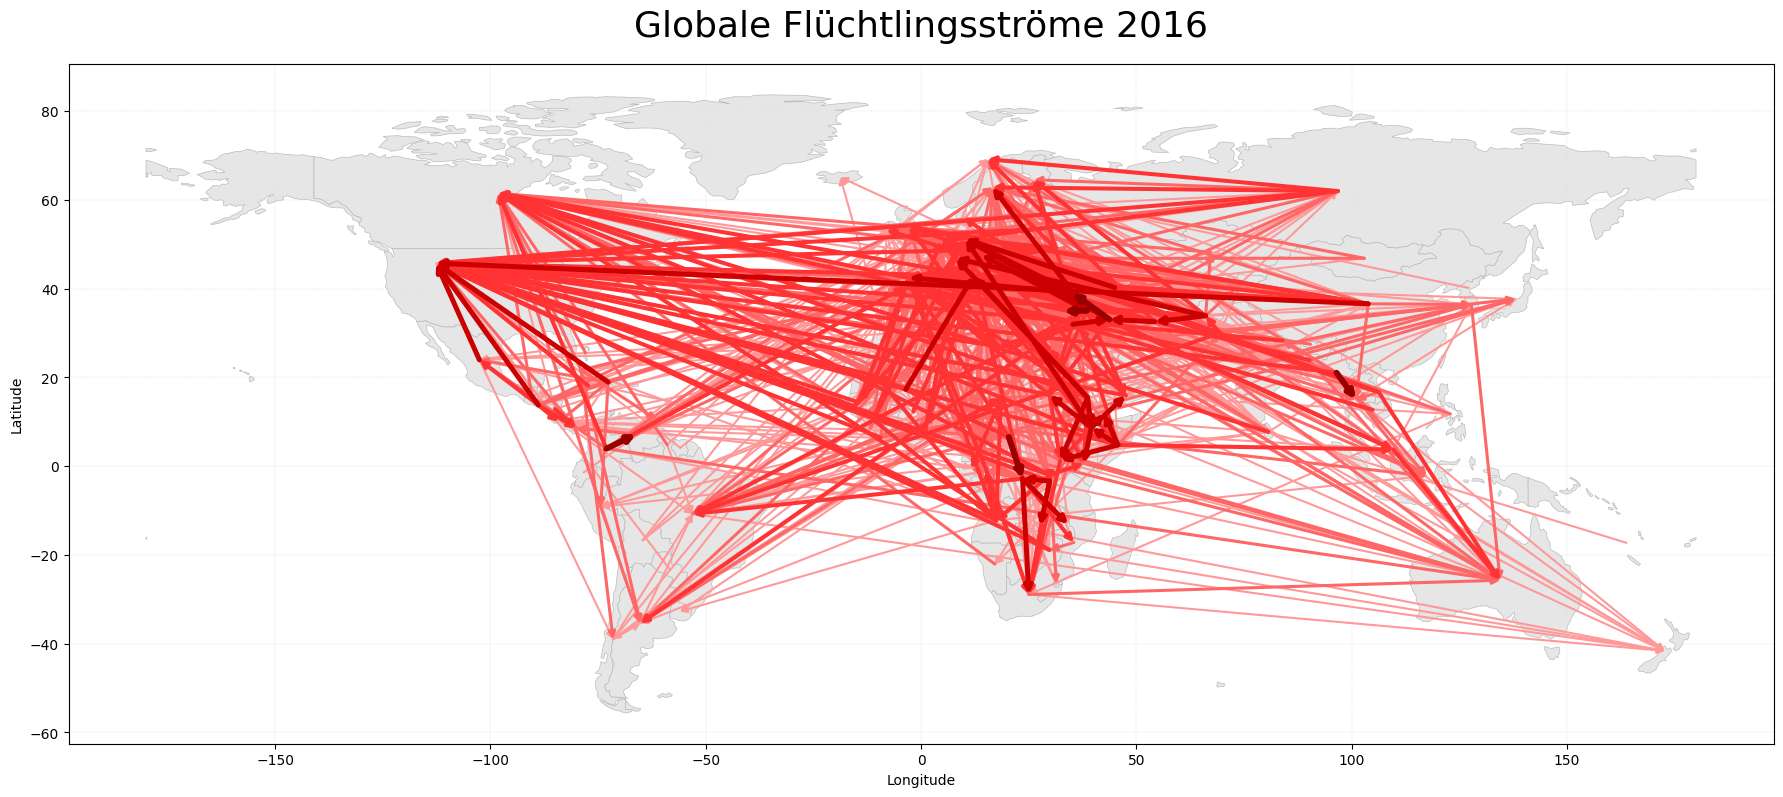

In [30]:
# %%
plot_flow_map(
    world,
    flows,
    YEAR,
    title="Globale Flüchtlingsströme",
    max_flows=1000
)


In [31]:
# %%
COUNTRY_TO_CONTINENT = dict(zip(world["country"], world["continent"]))

def get_continent(country):
    return COUNTRY_TO_CONTINENT.get(country, None)

flows["origin_continent"] = flows["Origin_clean"].apply(get_continent)
flows["asylum_continent"] = flows["Asylum_clean"].apply(get_continent)

print("Fehlende origin_continent:",
      flows["origin_continent"].isna().mean())


Fehlende origin_continent: 0.03625862345579978


In [32]:
# %%
def plot_all_continents(world, flows, year, max_flows=300):

    continents = flows["origin_continent"].dropna().unique()

    for cont in continents:
        subset = flows[flows["origin_continent"] == cont]

        if subset.empty:
            continue

        print(f"Plot {cont} ({len(subset)} Flows)")
        plot_flow_map(
            world,
            subset,
            year,
            title=f"Refugee Flows from {cont}",
            max_flows=max_flows
        )


Plot Asia (2022 Flows)


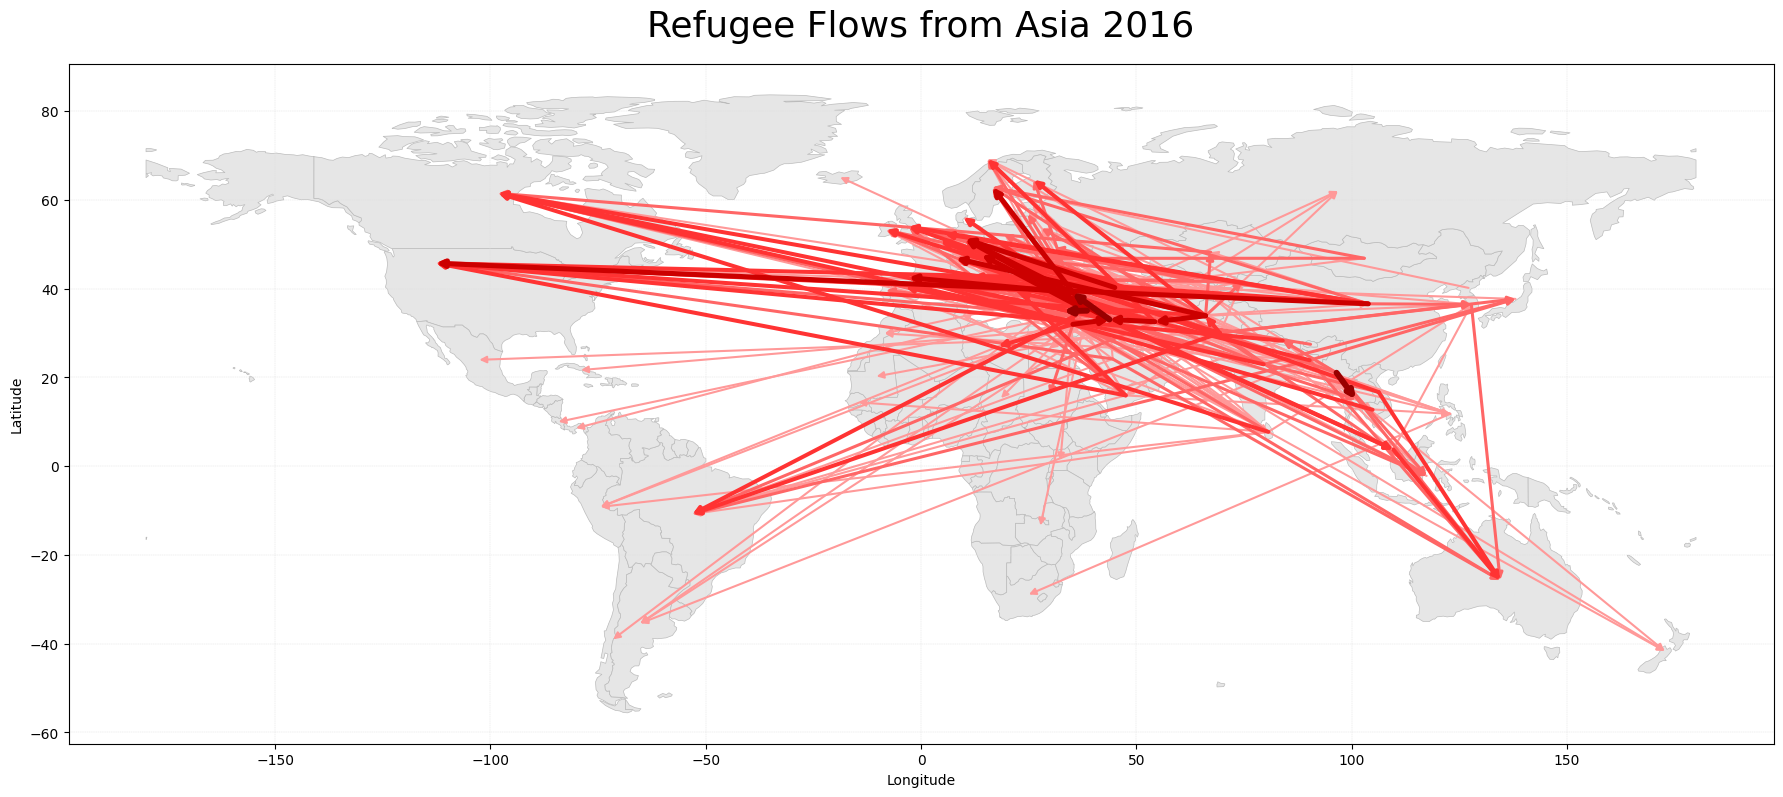

Plot Europe (685 Flows)


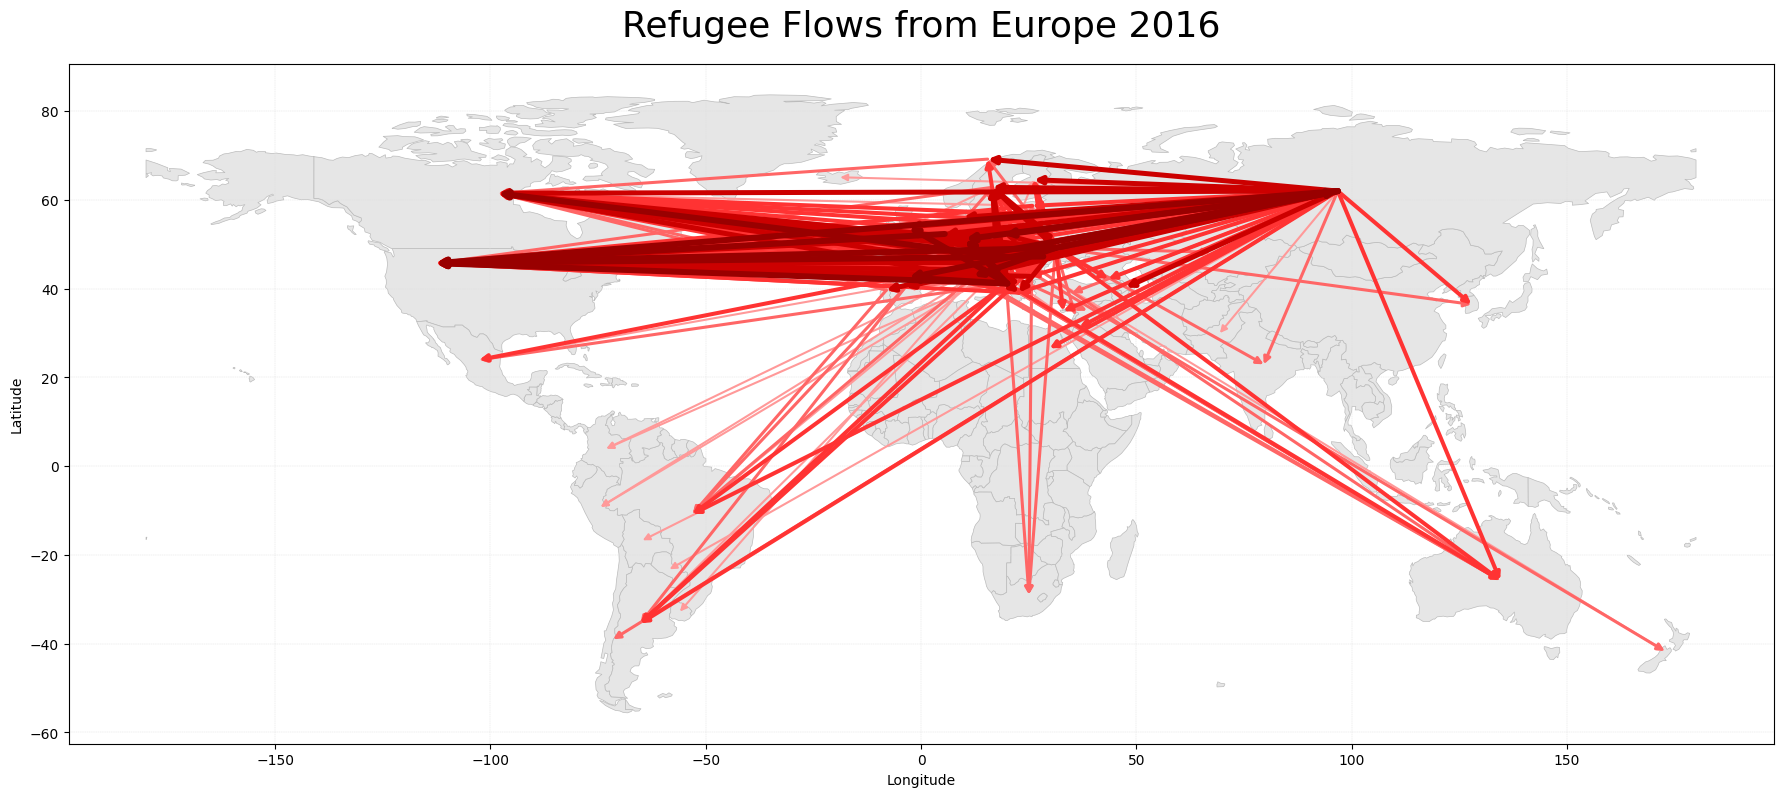

Plot Africa (2619 Flows)


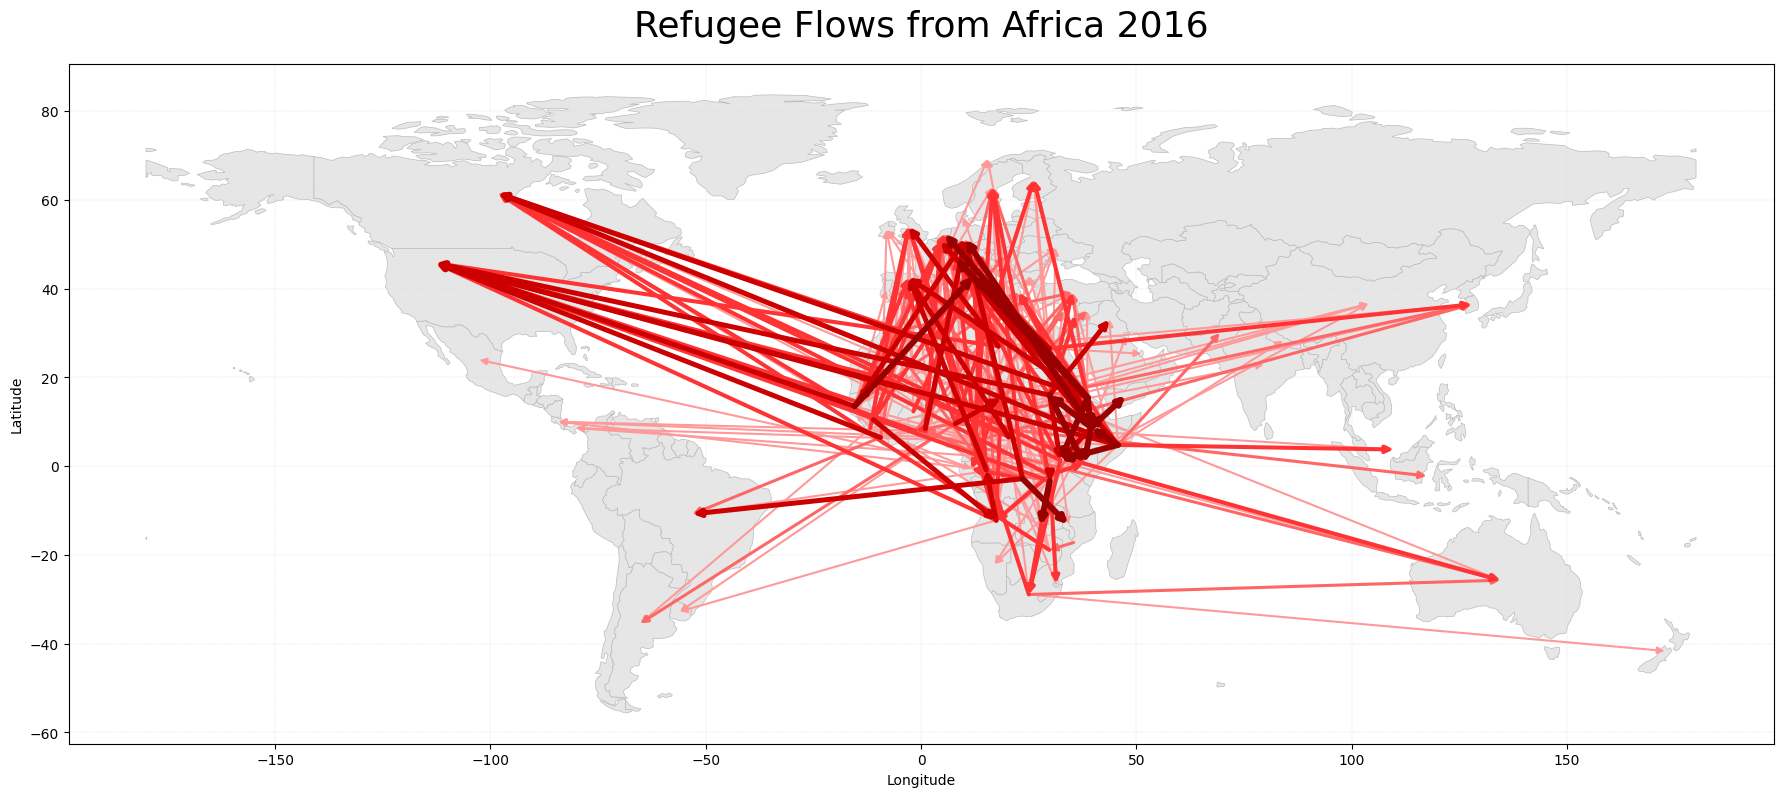

Plot South America (296 Flows)


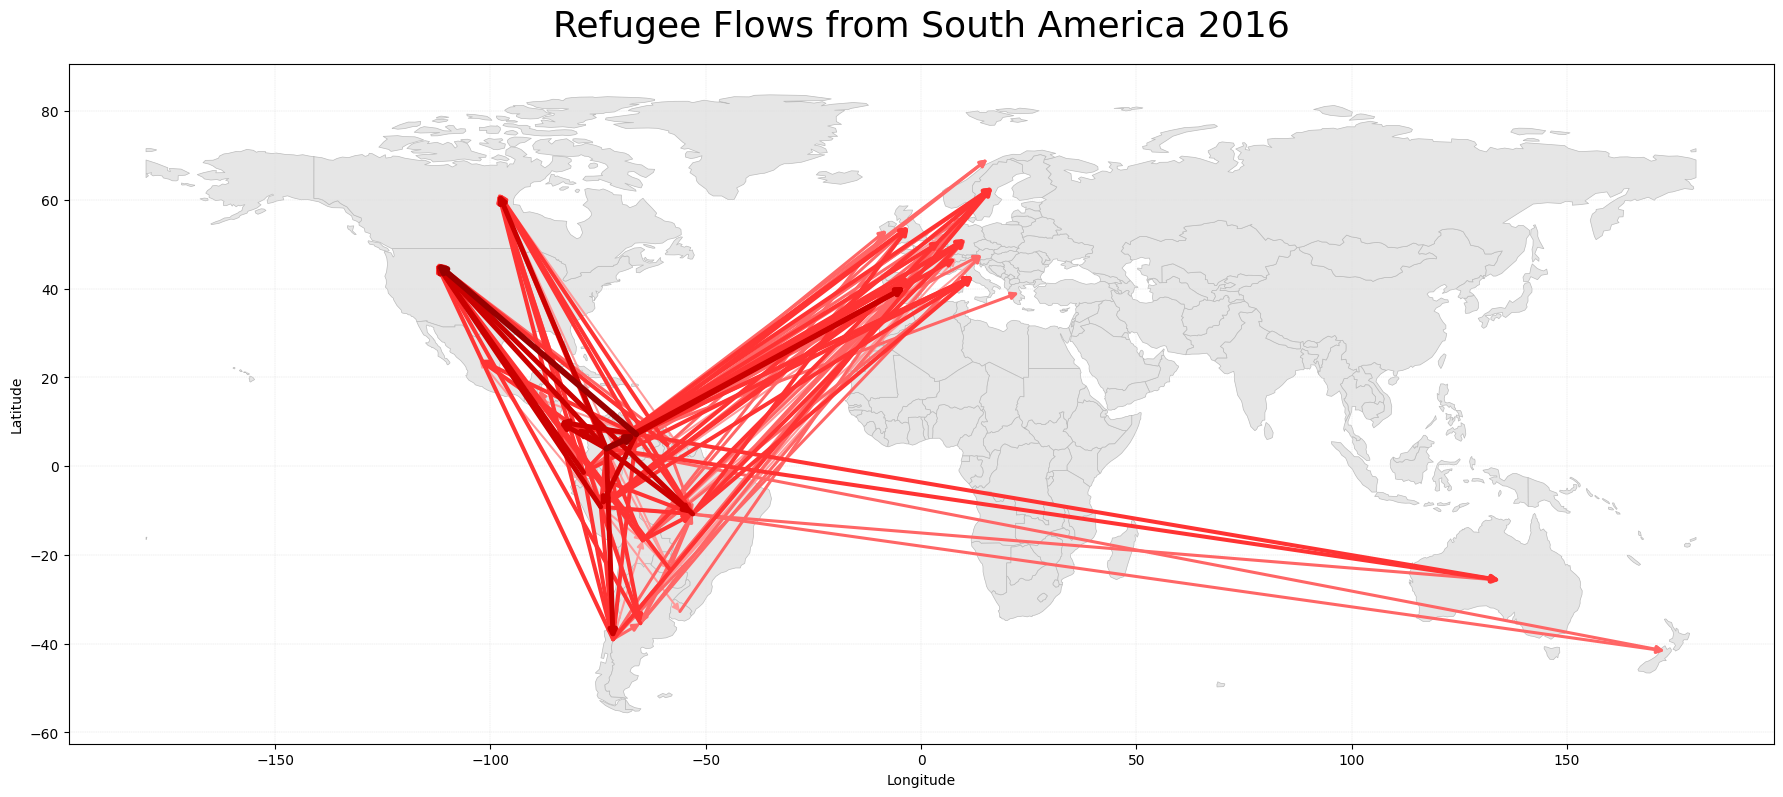

Plot Oceania (31 Flows)


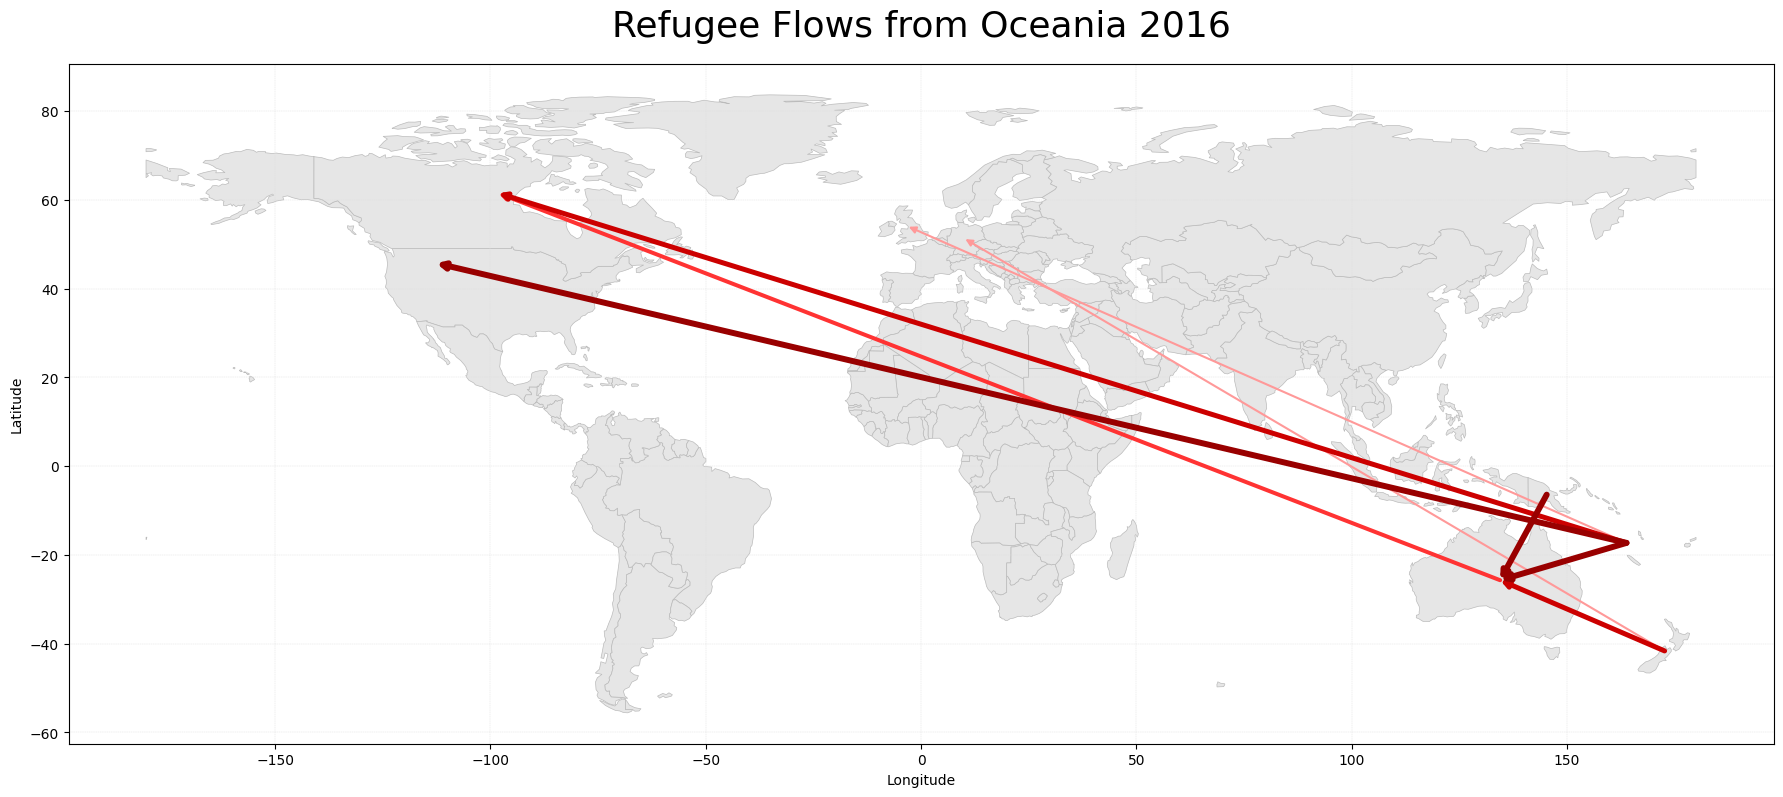

Plot North America (354 Flows)


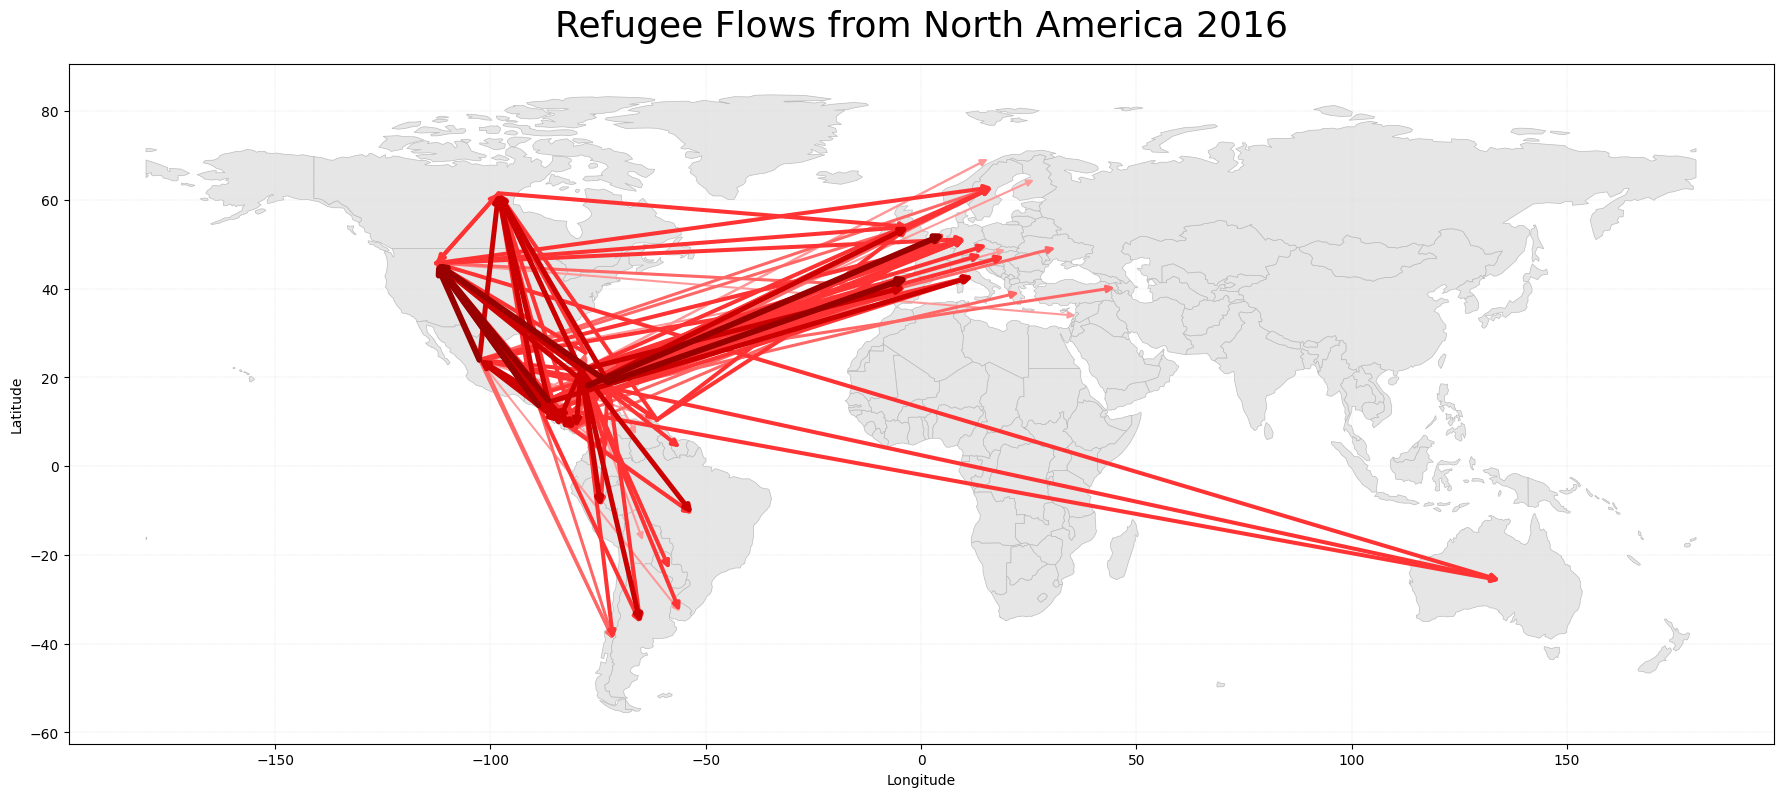

In [33]:
# %%
plot_all_continents(world, flows, YEAR, max_flows=300)


In [34]:
# %%
def plot_all_continents_inbound(world, flows, year, max_flows=300):

    continents = flows["asylum_continent"].dropna().unique()

    for cont in continents:
        subset = flows[flows["asylum_continent"] == cont]

        if subset.empty:
            continue

        print(f"Inbound {cont} ({len(subset)} Flows)")
        plot_flow_map(
            world,
            subset,
            year,
            title=f"Refugee Inflows into {cont}",
            max_flows=max_flows
        )


Inbound Asia (1016 Flows)


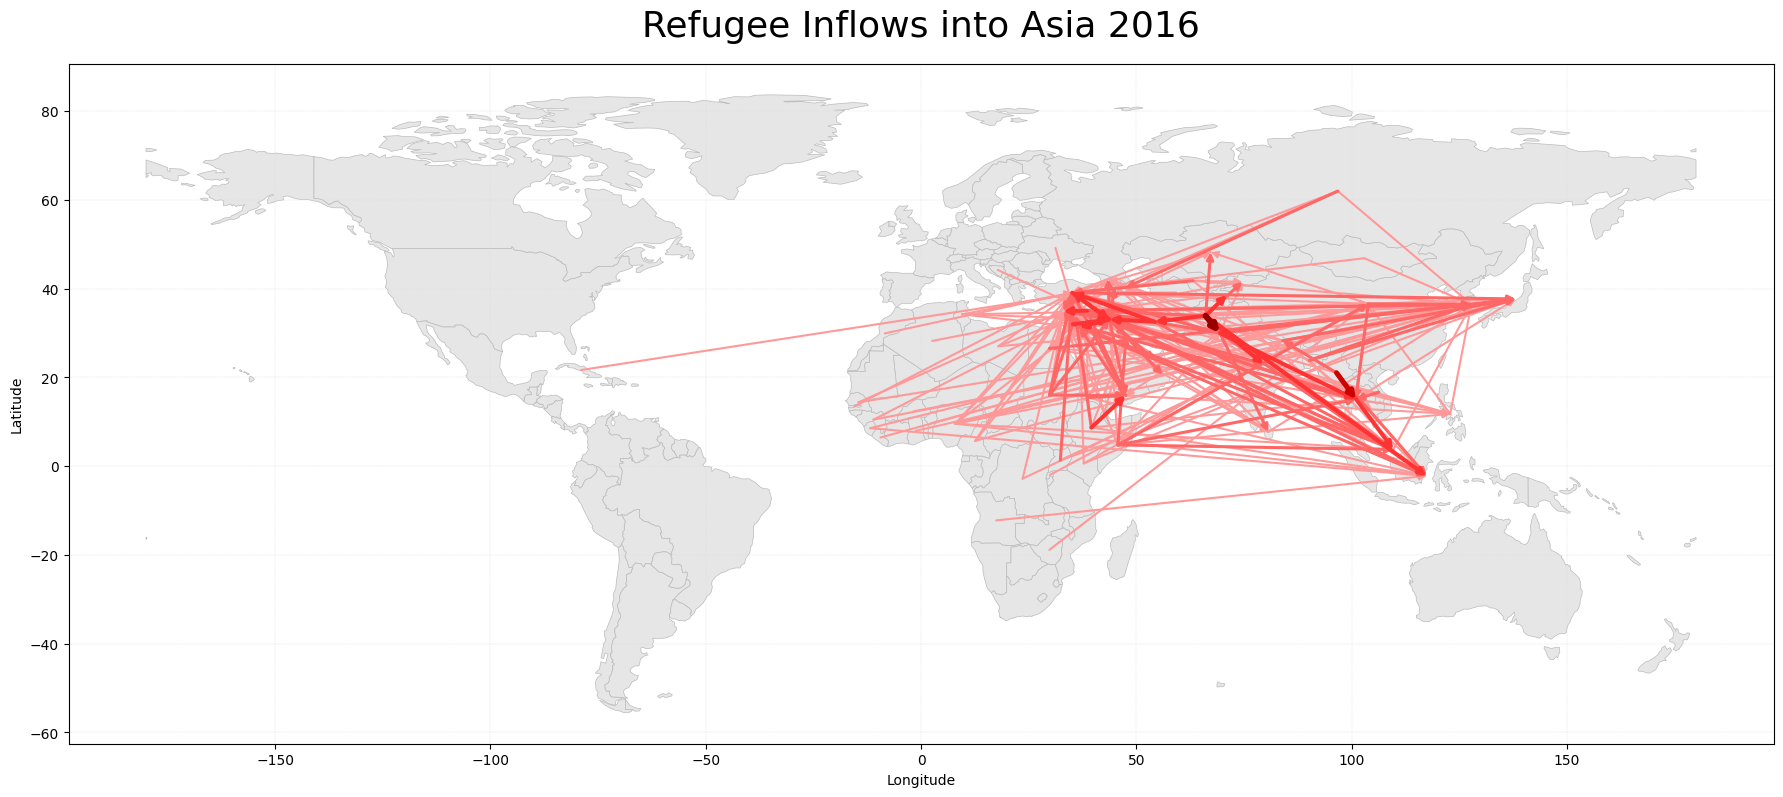

Inbound Africa (1119 Flows)


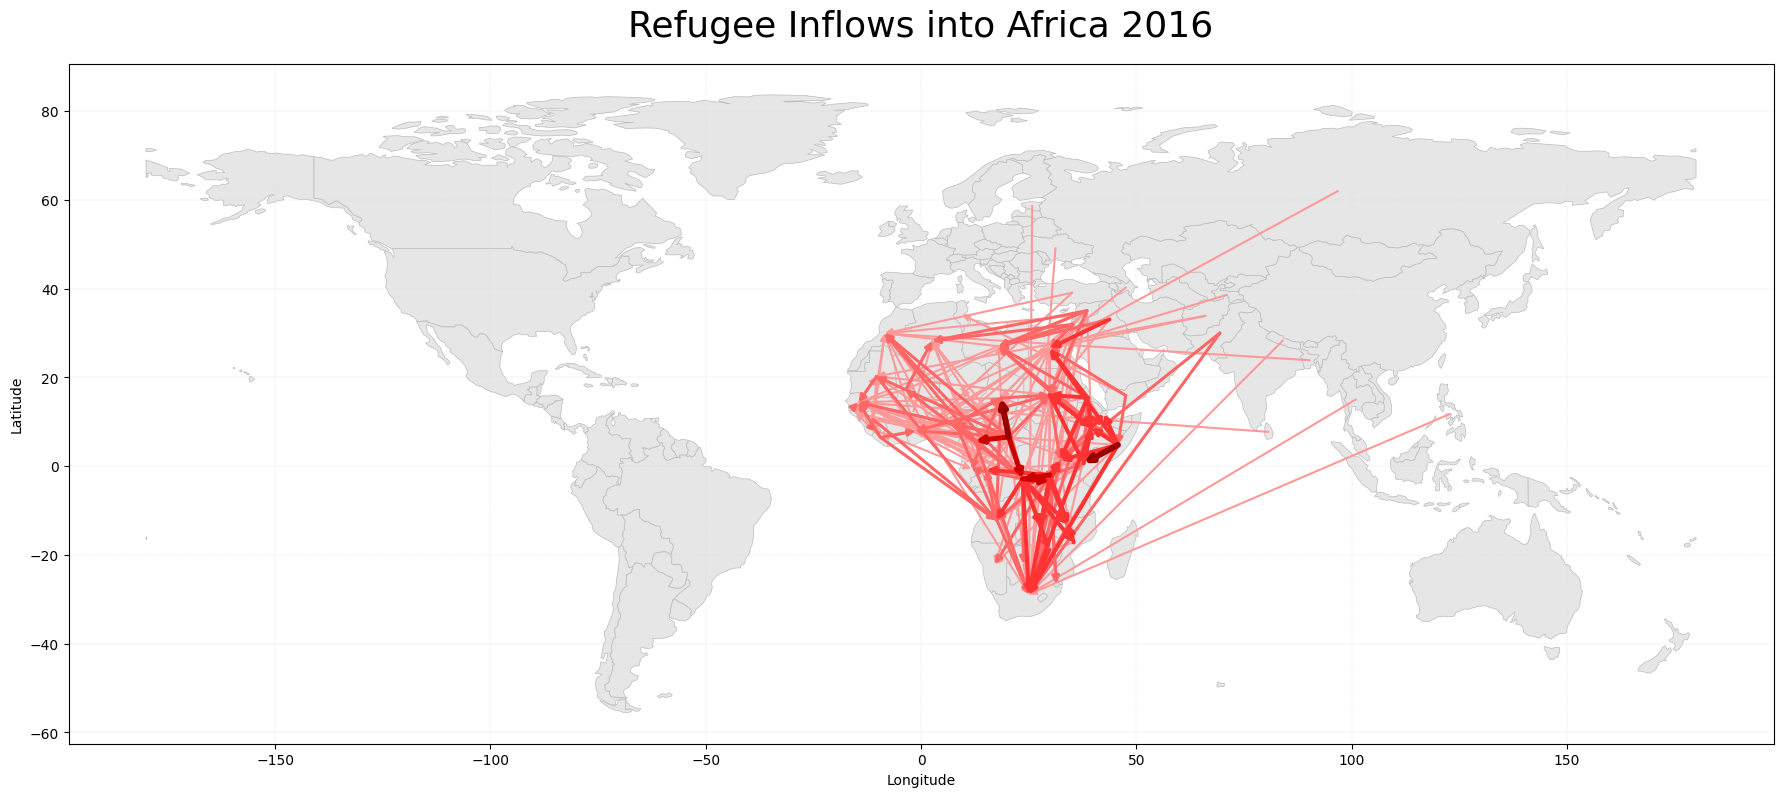

Inbound South America (508 Flows)


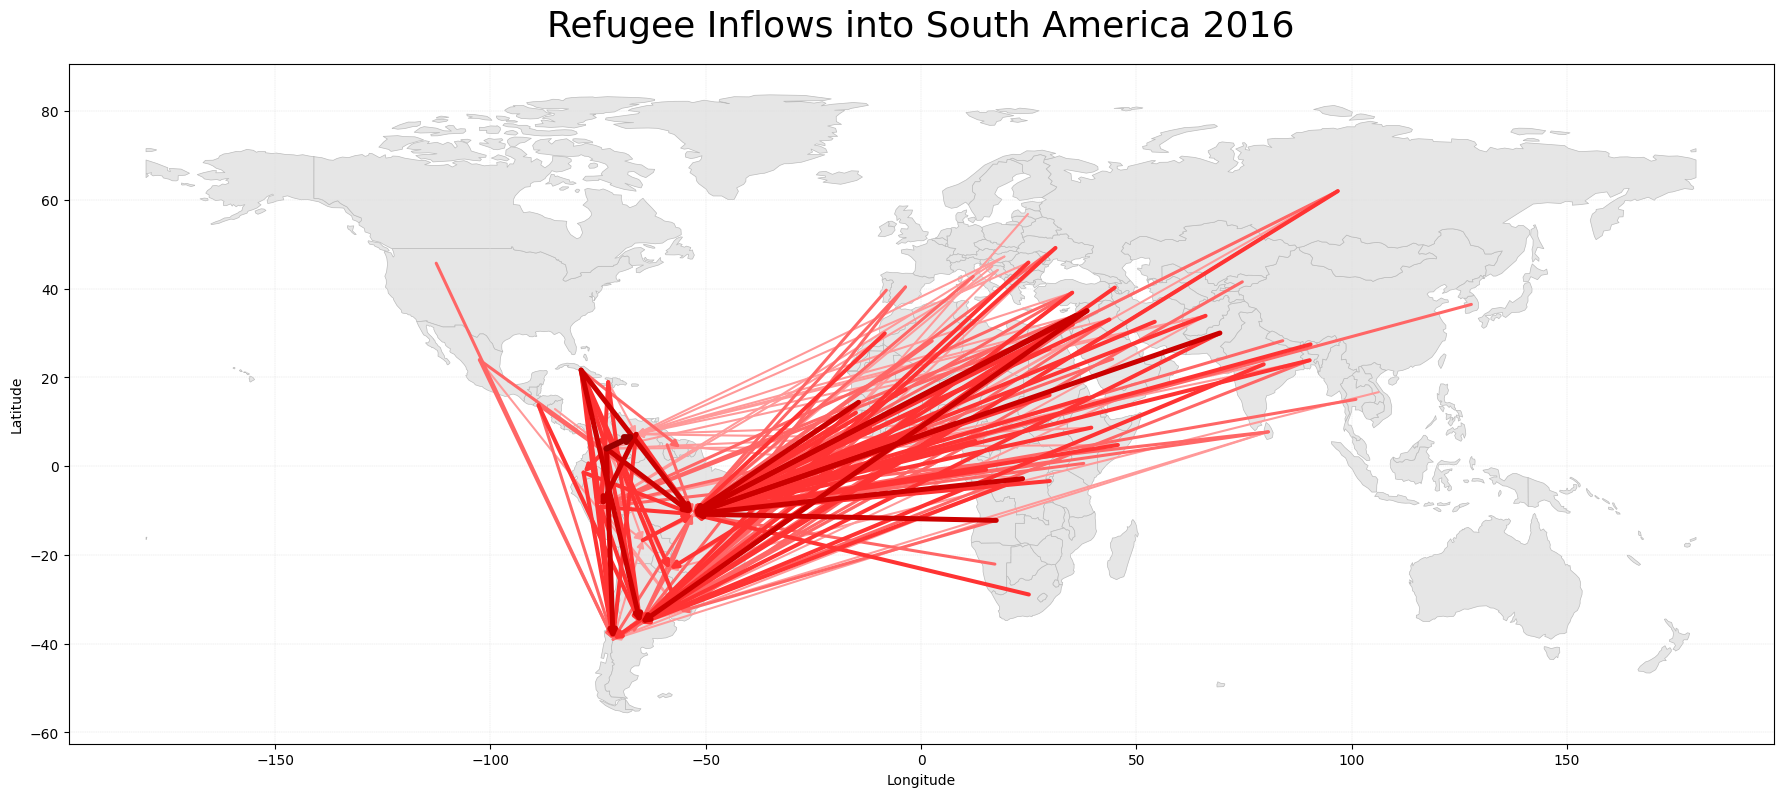

Inbound Oceania (224 Flows)


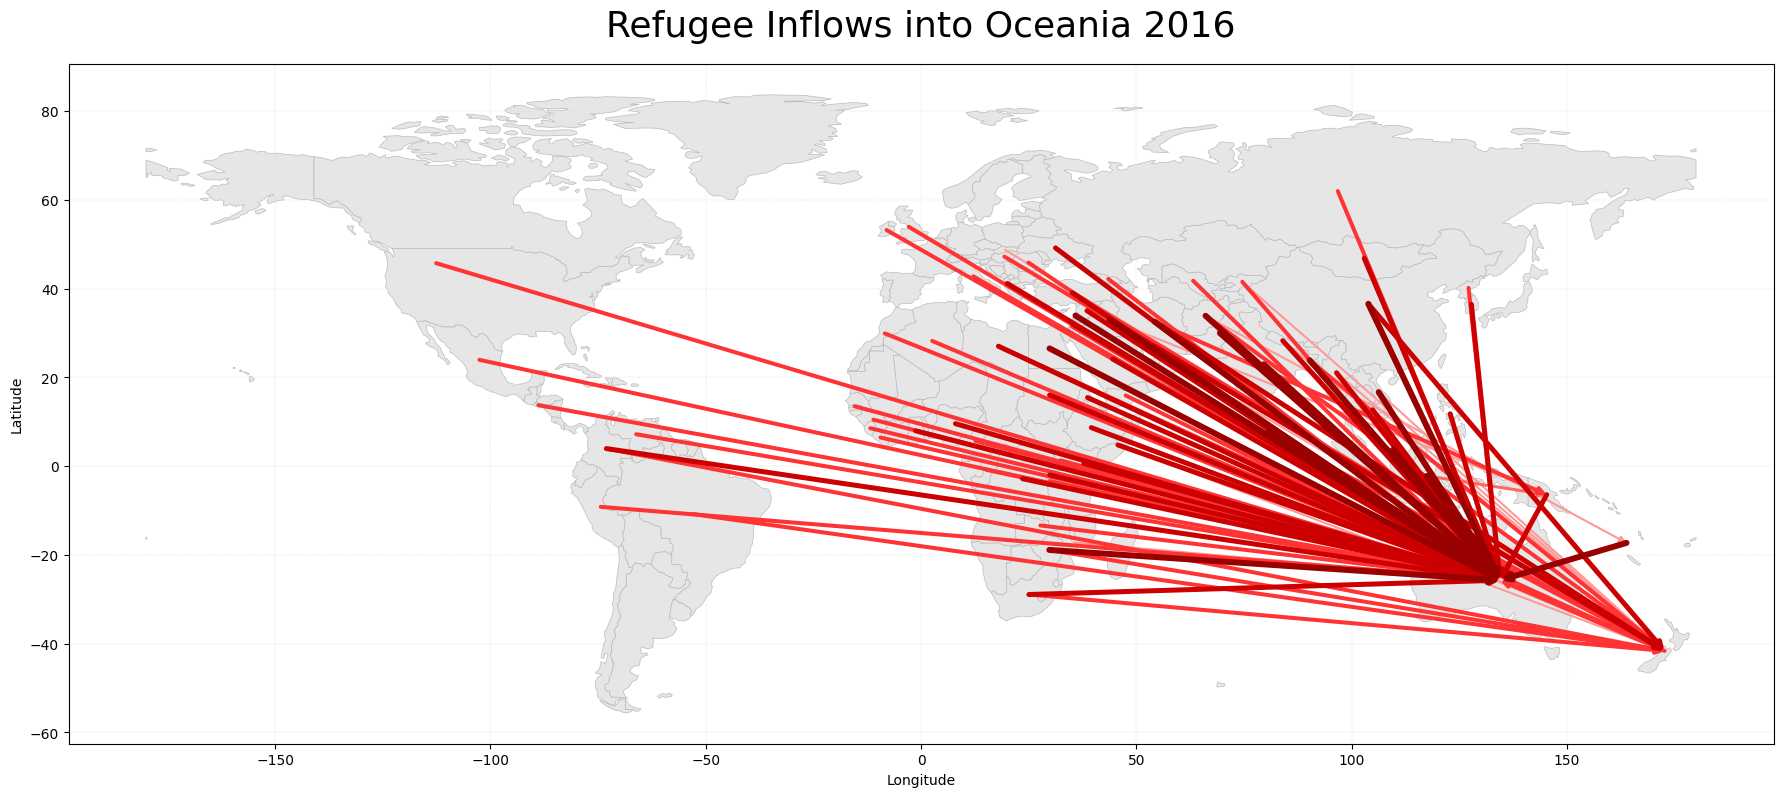

Inbound Europe (2680 Flows)


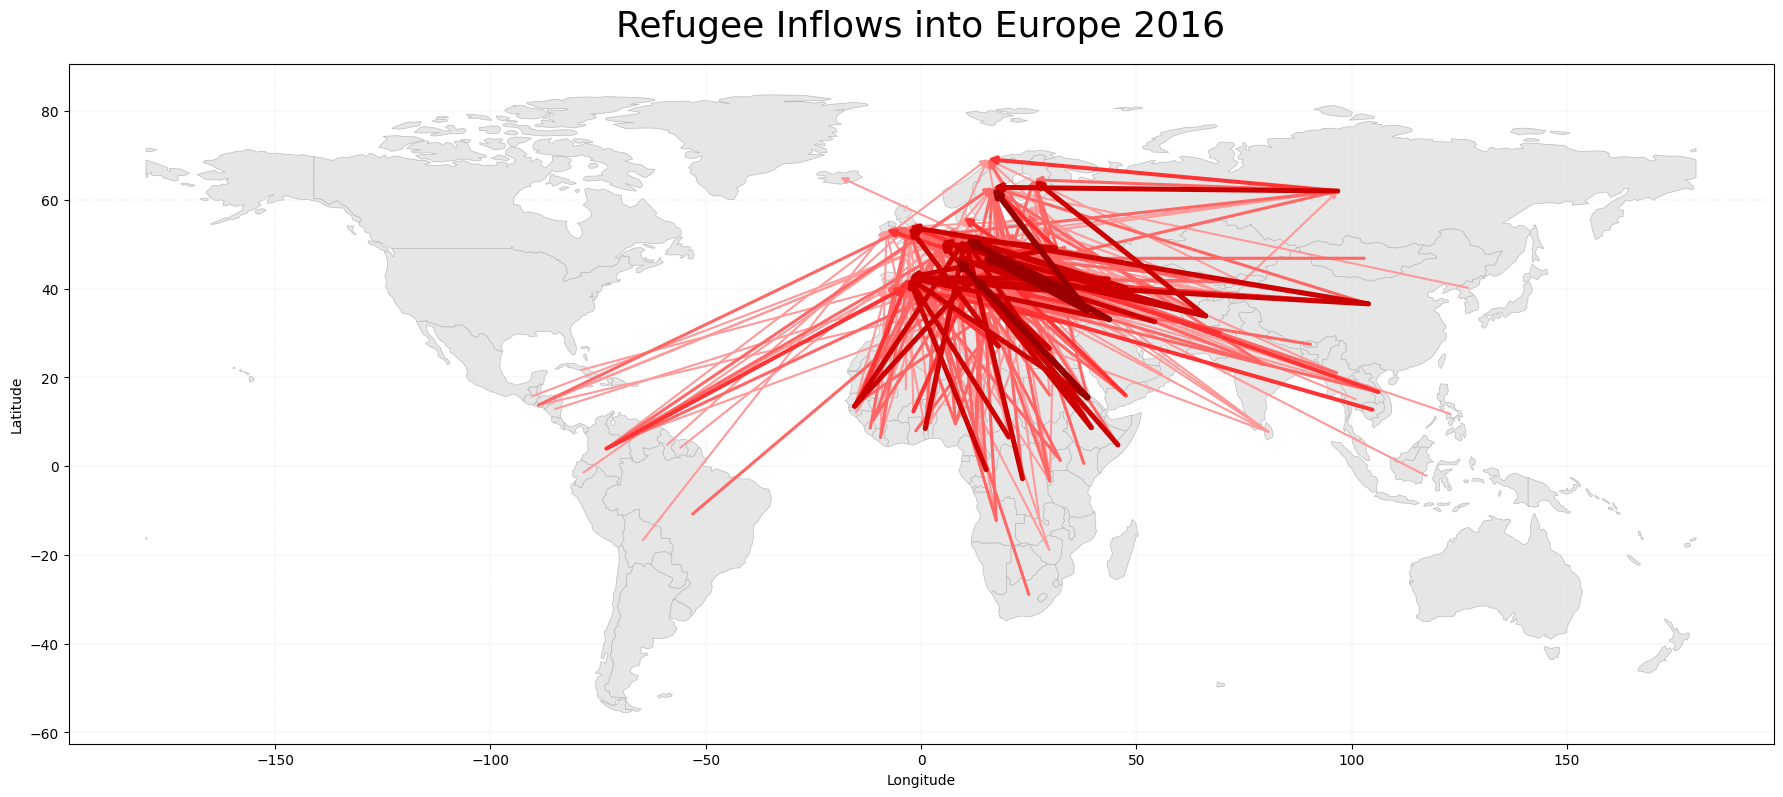

Inbound North America (606 Flows)


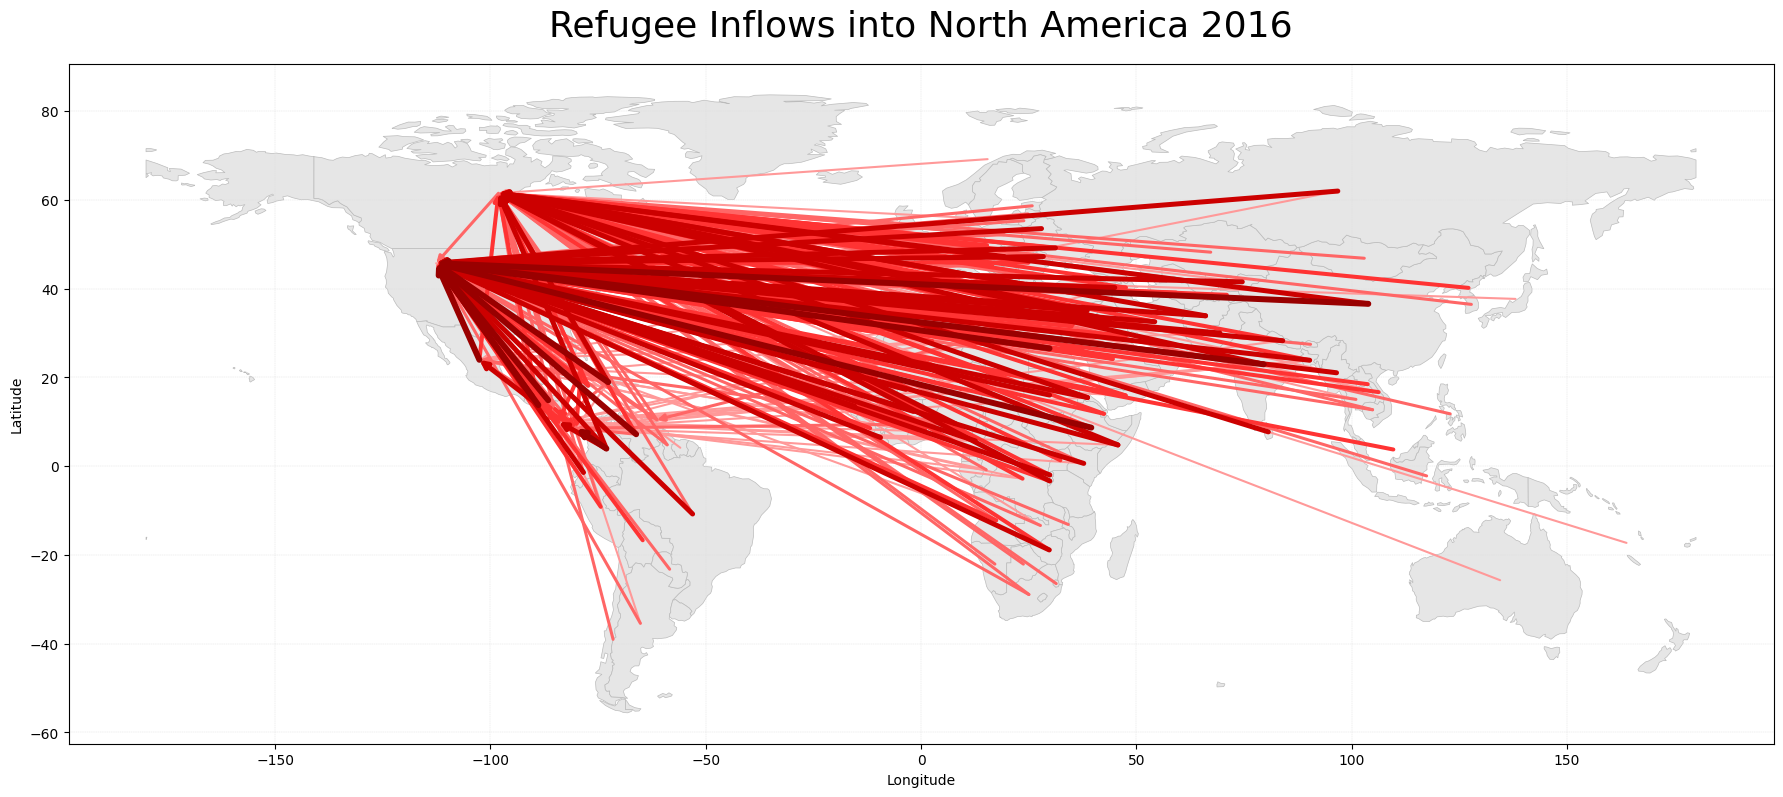

In [35]:
# %%
plot_all_continents_inbound(world, flows, YEAR, max_flows=300)


In [36]:
# %%
def plot_country_flows(world, flows, year, country, max_flows=300):

    flows_from = flows[flows["Origin_clean"] == country]
    flows_into = flows[flows["Asylum_clean"] == country]

    if not flows_from.empty:
        plot_flow_map(
            world,
            flows_from,
            year,
            title=f"Refugee Flows FROM {country}",
            max_flows=max_flows
        )

    if not flows_into.empty:
        plot_flow_map(
            world,
            flows_into,
            year,
            title=f"Refugee Flows INTO {country}",
            max_flows=max_flows
        )


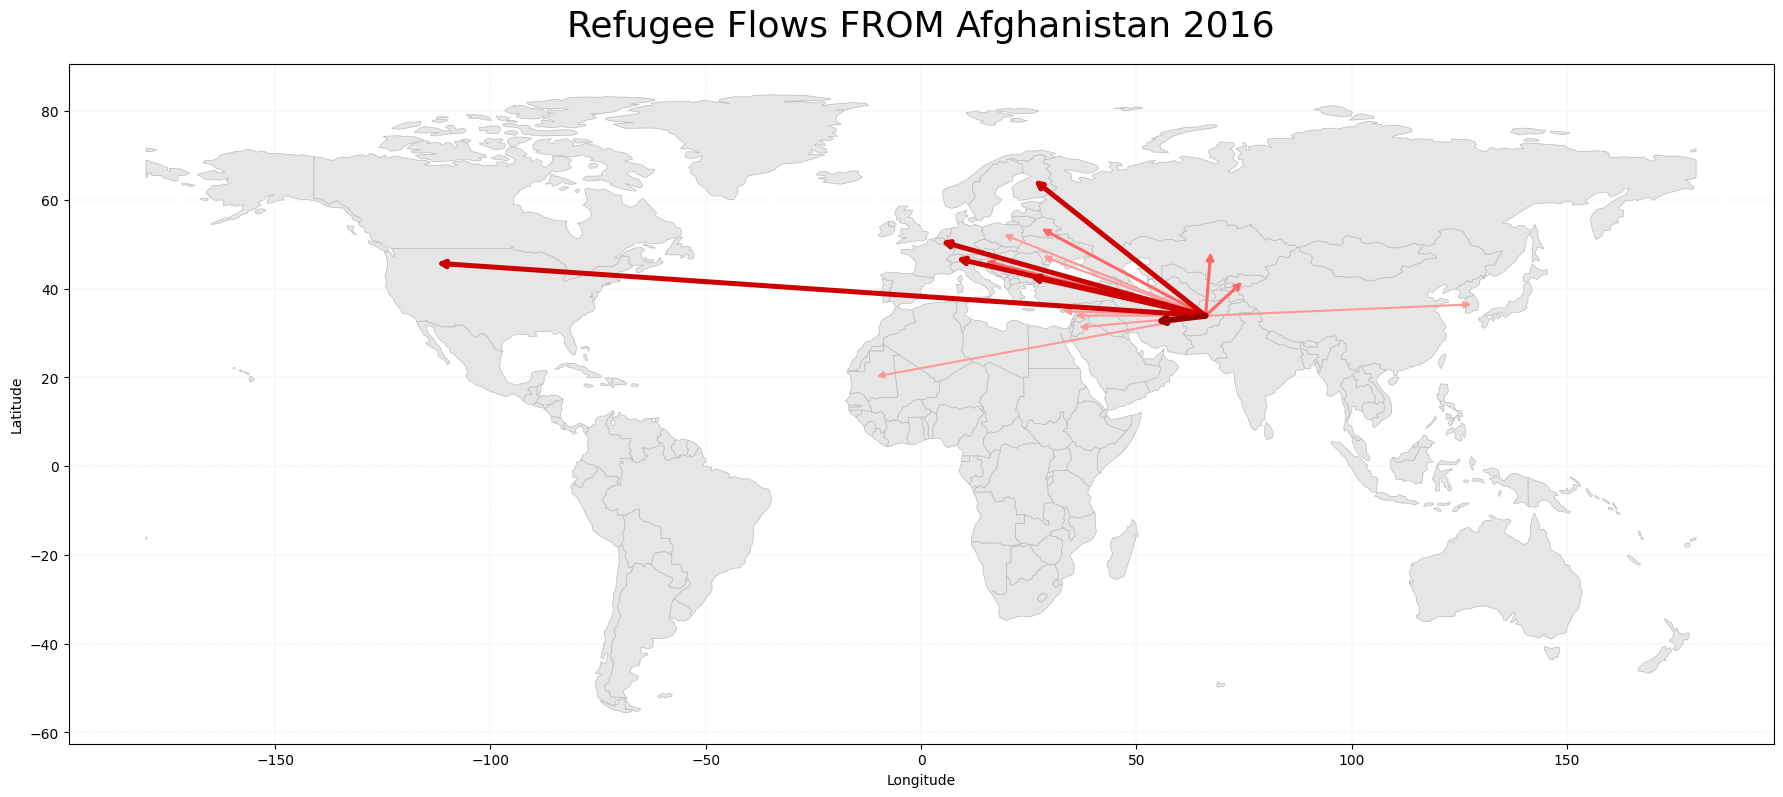

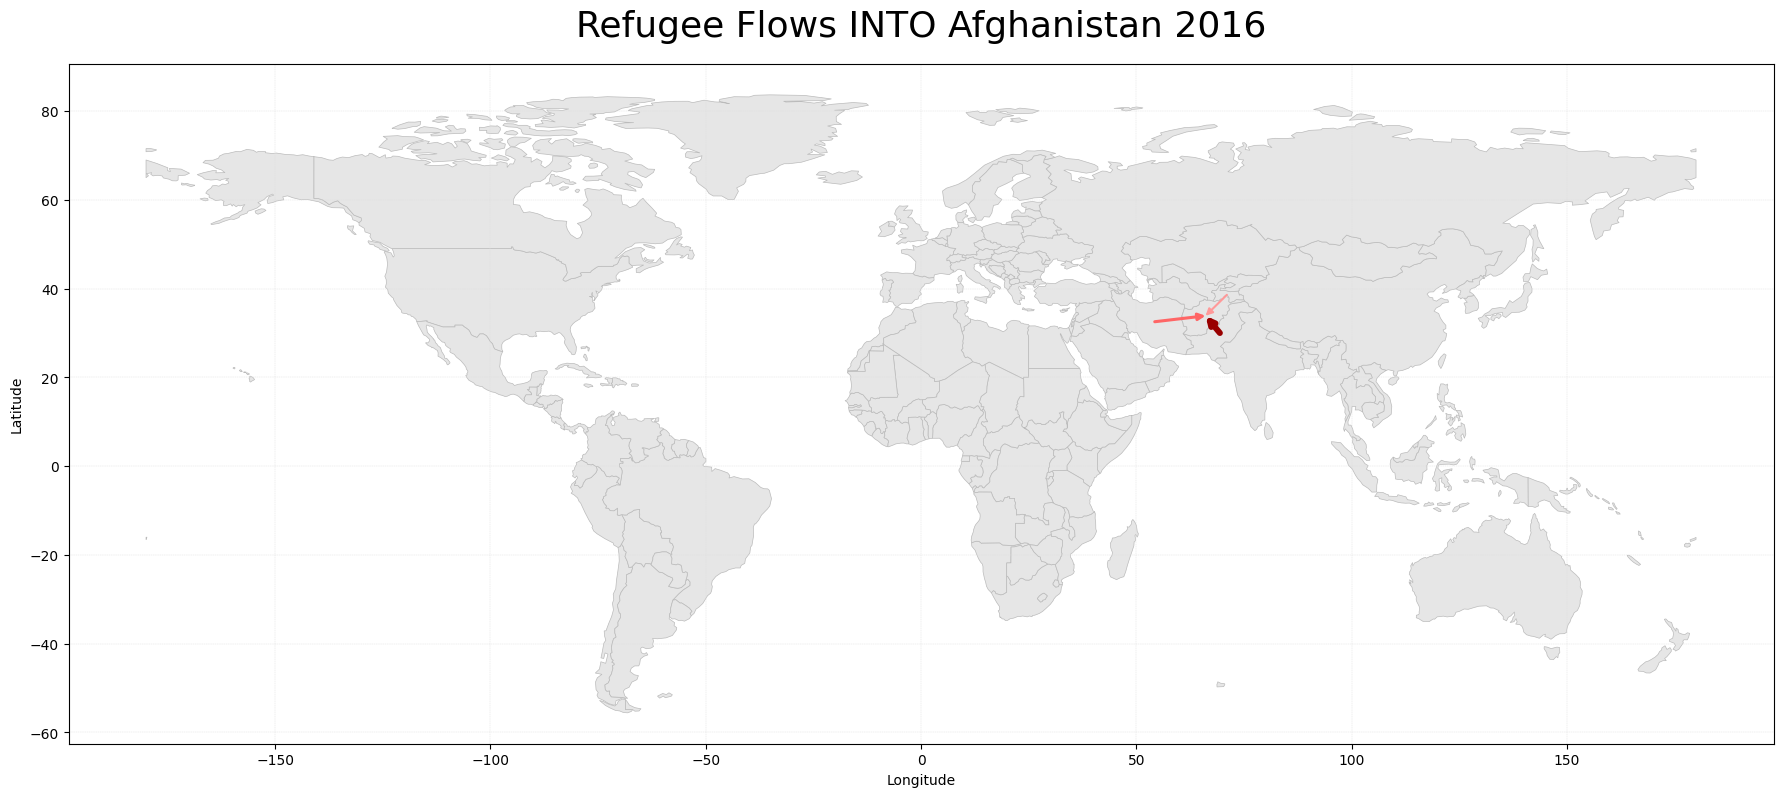

In [37]:
# %%
plot_country_flows(
    world,
    flows,
    YEAR,
    country="Afghanistan",
    max_flows=20
)
